# Task

 There is a number of models of population growth. Three of the most popular are: logistic, Gomperts and
Richards models (see e.g. [TW02]). Try to find the best mean-square fit of each of these models for the data
about the population in Poland from 1950 to 2020 that can be found on macrotrends.net. Apply each of
the three models to find the population in 2021. Which gives the best estimate? Which had the smallest
mean-square error?
To find the best-fitting curves apply the Newton method with stepsize computed using Armijo rule.
[TW02] A.N. Tsoularis, J. Wallace, Analysis of Logistic Growth Models. Mathematical Biosciences 179(1):
21–55 (2002)

## Imports

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import polars as pl

## Logistic model

$$
\frac{\partial}{\partial t}N=\frac{KN_0r(K-N_0)e^{rt}}{(K-N_0)e^{-rt}+N_0}
$$

$$
\frac{\partial^2}{\partial t^2}N=\frac{KN_0r^2(K-N_0)e^{2rt}(2K+N_0(e^{rt}-2))}{((K-N_0)(e^{rt}-1))^2}
$$

In [31]:
class LogisticGrowth:
    def __init__(self, K: float, N0: float, r: float) -> None:
        self.K = K
        self.N0 = N0
        self.r = r

    def x(self, t: float) -> float:
        return (self.K*self.N0) / ((self.K - self.N0)*np.exp(-self.r*t) + self.N0)
    
    def dx(self, t: float) -> float:
        return (
            (self.K * self.N0 * self.r * (self.K - self.N0) * np.exp(-self.r*t)) / 
            ((self.K-self.N0) * np.exp(-self.r*t) + self.N0) ** 2
        )
    
    def ddx(self, t: float) -> float:
        return (
            (self.K * self.N0 * self.r**2 * (self.K - self.N0) * np.exp(-self.r*t) * (self.N0-(self.K-self.N0)*np.exp(-self.r*t))) / 
            ((self.K-self.N0)*np.exp(-self.r*t) + self.N0)**3
        )
    

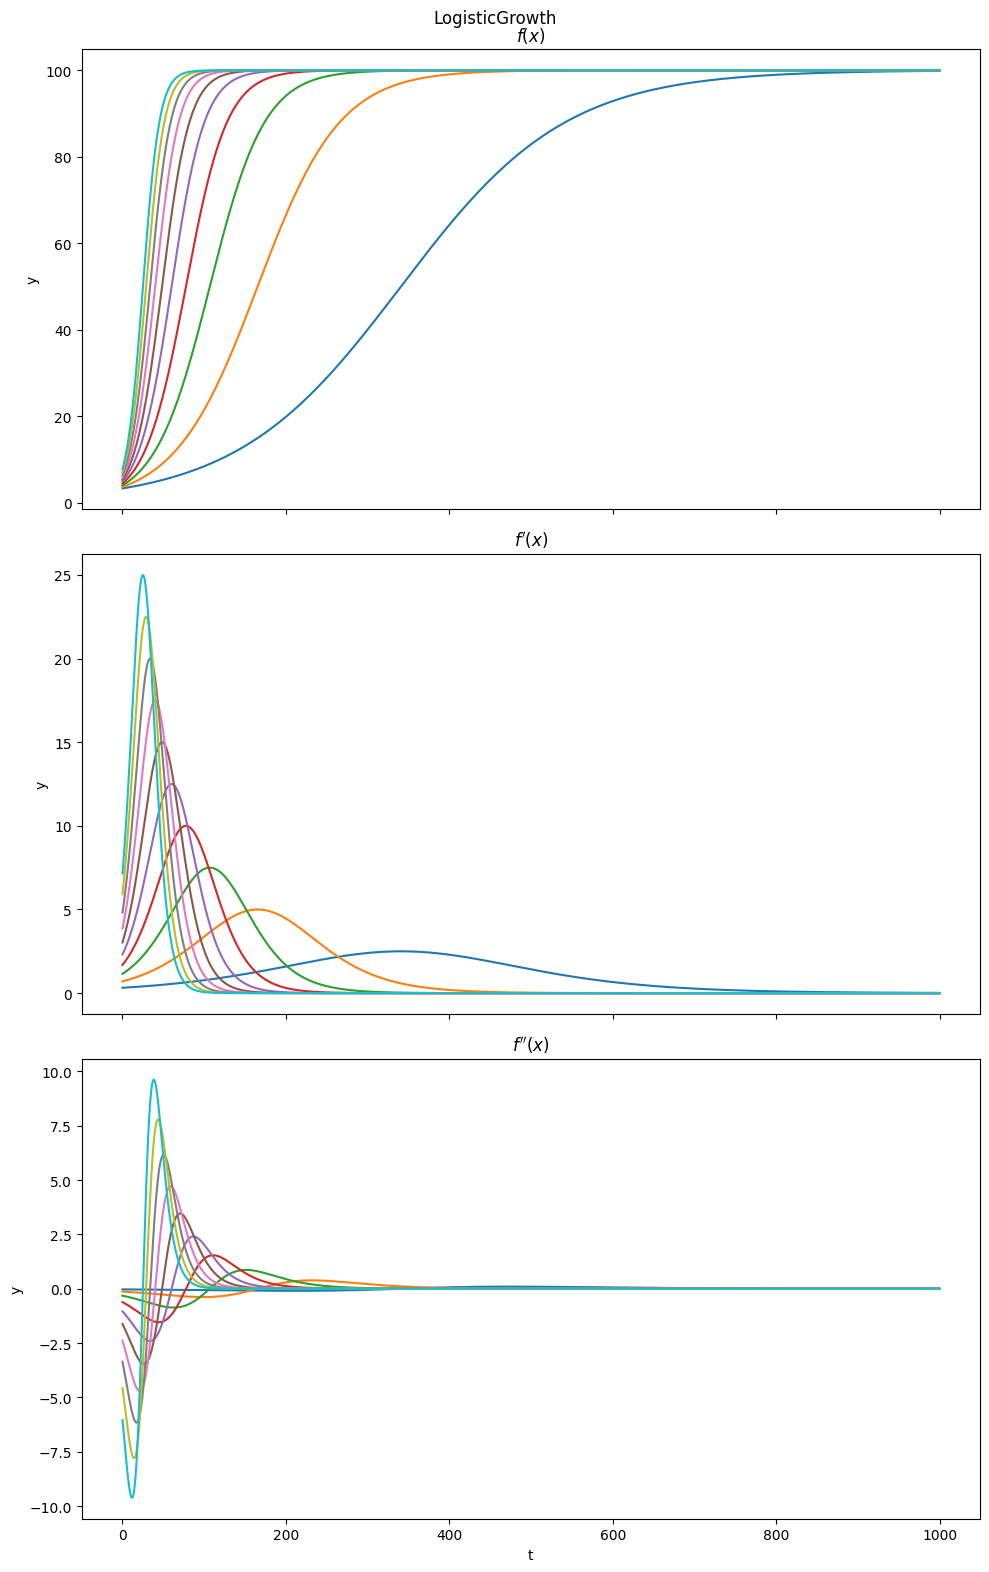

In [66]:
rs = np.linspace(0.1, 1, 10)
example_models = [LogisticGrowth(K=100, N0=3, r=r) for r in rs]
ts = np.linspace(1, 100, 1000)
fig, ax = plt.subplots(3, 1, figsize=(10, 16), sharex=True)
for r, model in zip(rs, example_models):
    ax[0].plot(model.x(ts), label=f"r={r}")
    ax[0].set_title("$f(x)$")
    ax[0].set_ylabel("y")
for r, model in zip(rs, example_models):
    ax[1].plot(model.dx(ts), label=f"r={r}")
    ax[1].set_title("$f'(x)$")
    ax[1].set_ylabel("y")
for r, model in zip(rs, example_models):
    ax[2].set_title("$f''(x)$")
    ax[2].plot(model.ddx(ts), label=f"r={r}")
    ax[2].set_ylabel("y")

ax[2].set_xlabel("t")
fig.suptitle("LogisticGrowth")
fig.tight_layout()

In [68]:
def mse(y, y_pred):
    return np.mean((y - y_pred)**2)

In [69]:
real_data = pl.read_csv("population.csv")
years = real_data["Year"].to_numpy()[:-5]
populations = real_data["Population"].to_numpy()[:-5]

In [70]:
constrains = {
    "K": (3e6, 120e6),
    "N0": (0, 1e8),
    "r": (0, 0.2),
}
t0 = 1950

In [73]:
def fit_logistic_numpy(ts, xs, constrains, steps=1_000):
    K_values = np.linspace(*constrains["K"], steps)
    r_values = np.linspace(*constrains["r"], steps)
    N0_values = np.linspace(*constrains["N0"], steps)

    best_params = None
    best_mse = np.inf
    mse_history = []

    for K in K_values:
        for r in r_values:
            for N0 in N0_values:
                model = LogisticGrowth(K=K, N0=N0, r=r)
                preds = model.x(ts)
                current_mse = mse(xs, preds)
                mse_history.append(current_mse)

                if current_mse < best_mse:
                    best_mse = current_mse
                    best_params = (K, r, N0)

    return best_params, best_mse, mse_history

params, error, mse_history = fit_logistic_numpy(
    years-t0, populations, constrains=constrains,
    steps=50
)

K_opt, r_opt, N0_opt = params

print("Optimal parameters:")
print(f"K = {K_opt}")
print(f"r = {r_opt}")
print(f"N0 = {N0_opt}")
print("\nLowest MSE =", error)


Optimal parameters:
K = 38816326.530612245
r = 0.0653061224489796
N0 = 24489795.91836735

Lowest MSE = 324816779443.9906


In [ ]:
population_in_2021 = real_data.filter(pl.col("Year")==2021).select("Population")
population_in_2021

shape: (1, 1)
┌────────────┐
│ Population │
│ ---        │
│ i64        │
╞════════════╡
│ 36981559   │
└────────────┘

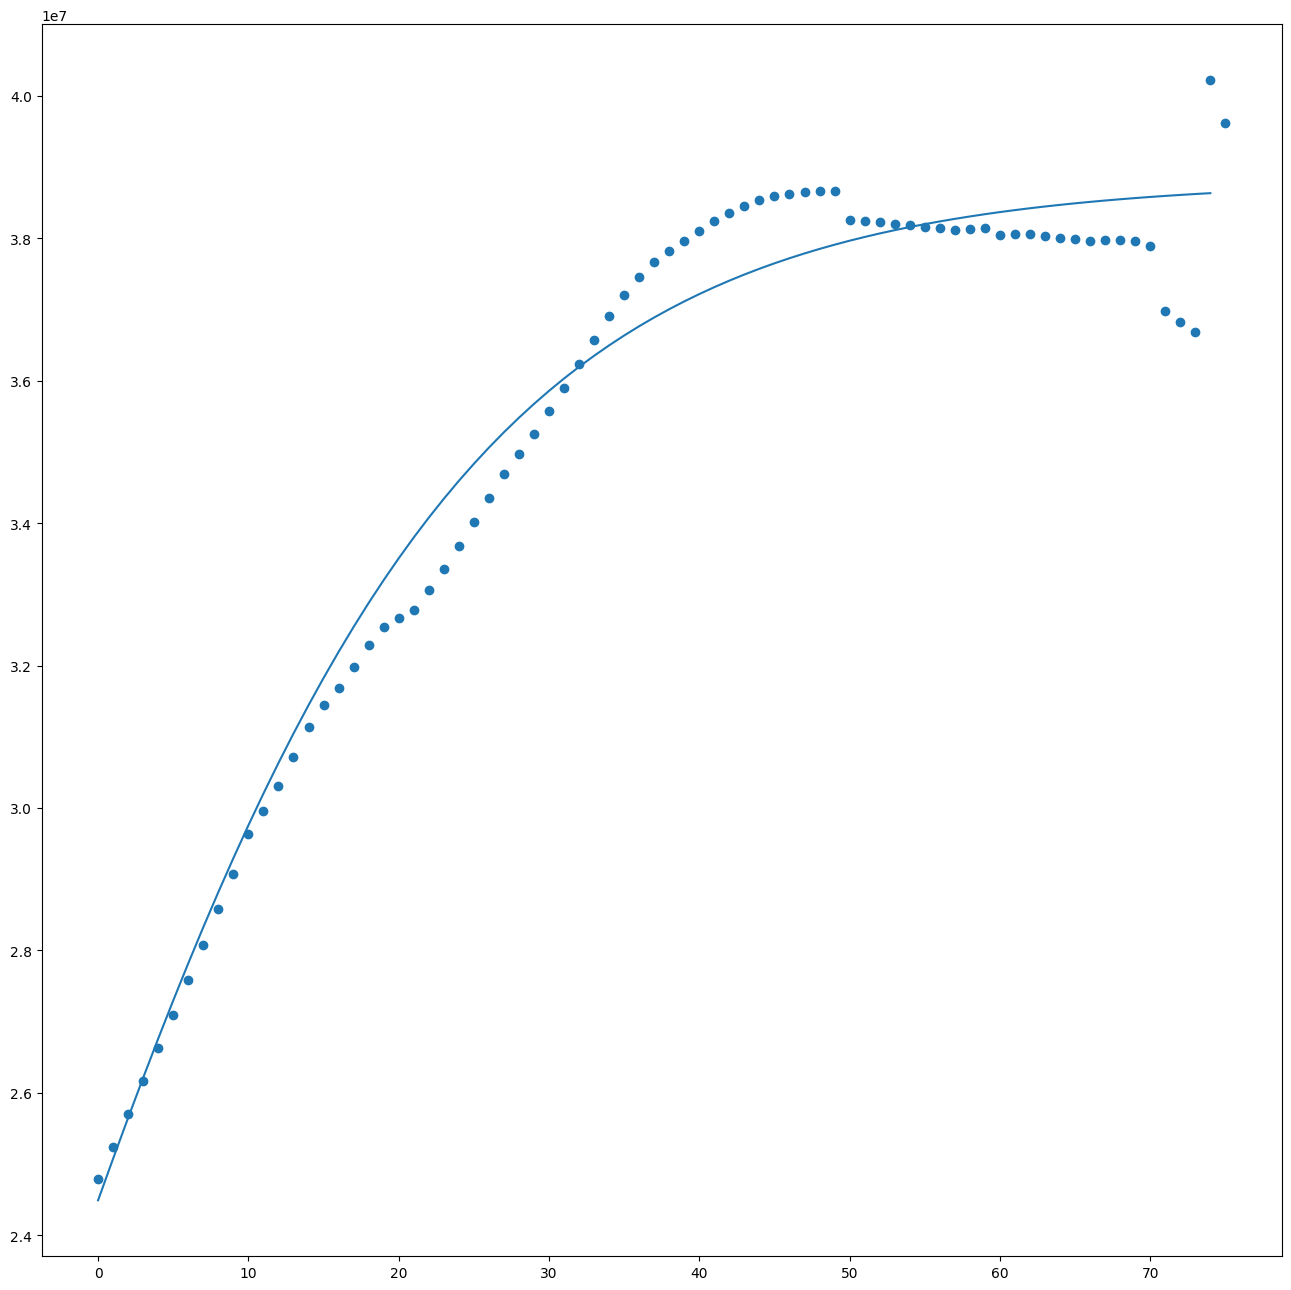

In [ ]:
model_fit = LogisticGrowth(K=K_opt, N0=N0_opt, r=r_opt)
ts = np.arange(1950, 2025) - 1950
fig, ax = plt.subplots(1, 1, figsize=(16, 16))
ax.plot(ts, model_fit.x(ts))
ax.scatter(real_data["Year"]-t0, real_data["Population"])
ax.scatter(real_data["Year"]-t0, real_data["Population"])

In [97]:
logistic_pred_error_rate = (np.abs(model_fit.x(2021) - population_in_2021) / population_in_2021)[0][0]
print(f"Logistic model error rate:{logistic_pred_error_rate:.3f}")

Logistic model error rate:0.050


In [51]:
def newton_method(model, x0: float, M: int, beta: float, delta: float, s:float) -> list[float]:
    """1D implementation for Newton method.
    For non-positive Dk we use set I like in steeepest descent method.
    """
    xs = [x0]
    for i in range(M):
        xi = xs[i]
        Dk = 1 / model.ddx(xi)
        Dk = 1 if Dk < 0 else Dk
        ak = get_armijo_stepsize(model, s, xi, Dk, beta, delta)
        x_new = xi - ak * Dk * model.dx(xi)
        xs.append(x_new)
    return xs

def get_armijo_stepsize(model, s: float, x: float, Dk: float, beta: float, delta: float):
    a = s
    while (
        model.x(x - a*Dk*model.dx(x)) >= (model.x(x) - delta*a*model.dx(x)*Dk*model.dx(x))
    ): a *= beta
    return a

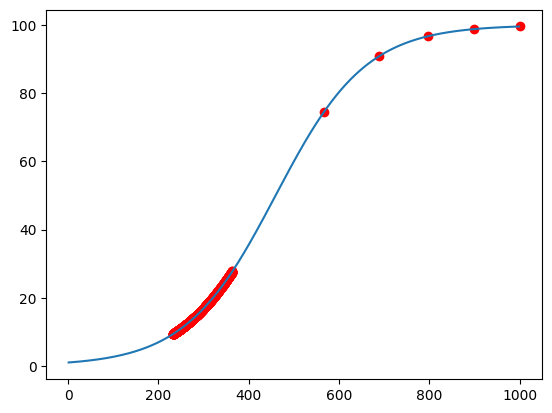

In [63]:
model = LogisticGrowth(K=100, N0=1, r=0.01)
steps = newton_method(model, s=1, x0=1000, beta=0.7, delta=0.7, M=1000)
steps = np.array(steps)
ts = np.arange(1, 1000)
plt.plot(ts, model.x(ts))
plt.scatter(steps, model.x(steps), c="r")